# Project : Movielens 영화 SBR

이번에 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

우선 주요 라이브러리 버전을 확인해 보죠.

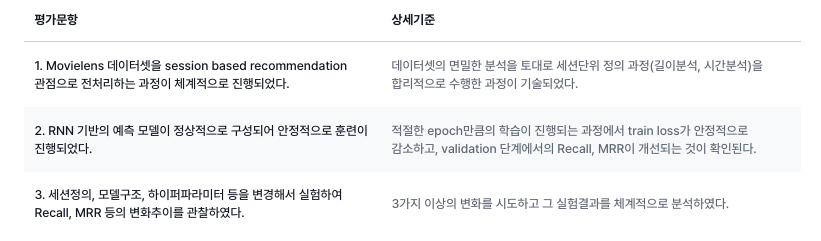

In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 0. 데이터 준비하기

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


시간 정보가 Unix 타임스탬프 형식으로 되어있다. (초단위) 이거를 연,월,일 단위 시간으로 보기 쉽게 바꾼다

In [4]:
# Unix 타임스탬프를 연월일 형식으로 변환
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.



# 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.



## | Basics

In [5]:
data.isna().sum()

UserId    0
ItemId    0
Rating    0
Time      0
dtype: int64

In [6]:
data[data.duplicated()]

,UserId,ItemId,Rating,Time


중복, N/A값은 없다

In [7]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

유저는 6040, 아이템은 3706개 있다

In [8]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

- 각 user가 얼마나 영화를 많이 봤는지 확인

In [9]:
user_length.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

In [10]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

- 중간값 81편, 평균 138편의 영화를 봤다

## | Session Length
- UserId당 Time 정보가 같은 경우 1개의 session으로 간주하면 될 것 같다
- 즉, 사용자가 한 날에 여러 영화를 시청한 경우, 이를 하나의 세션으로 처리한다

In [11]:
# session_length = data.groupby('UserId')['Time'].nunique()
# session_length.median()

In [12]:
# session_length.describe()

In [13]:
# session_length.quantile(0.9)

In [14]:
#예시) ID=4인 사람의 정보
# data[data.UserId == 4]

In [15]:
# data[data.UserId == 4]['Time'].nunique()

User Id = 4 인 사람이 총 21개의 영화에 대해 각각의 rating을 매긴 것, 7번의 session  
(Time 이 같은 경우, 한 번의 session으로 간주)

In [16]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

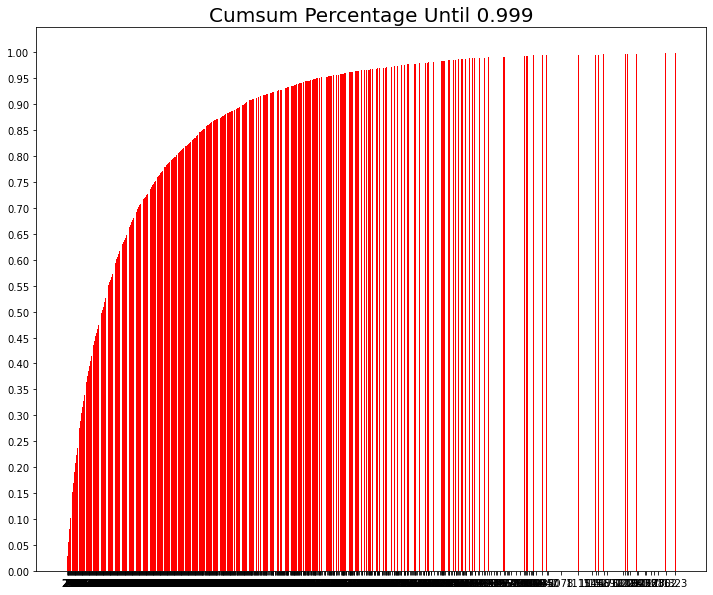

In [17]:
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

## | Session Time

In [18]:
#가장 오래된, 최근의 timestamp 확인
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest,',', latest)

2000-04-25 23:05:32 , 2003-02-28 17:49:50


총 3년치의 데이터가 있다. 그냥 3년치 데이터 다 쓰도록 한다

In [19]:
# year_ago = latest - dt.timedelta(365)     # 최종 날짜로부터 1년 이전 날짜를 구한다.  
# data = data[data['Time'] > year_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

## | Data Cleansing

- rating이 너무 작은 것들 (1, 2)은 선호하지 않는다고 판단하여 지운다. 즉, 사용자가 시청한 영화 중 평점이 높은 영화들을 고려할 수 있다.

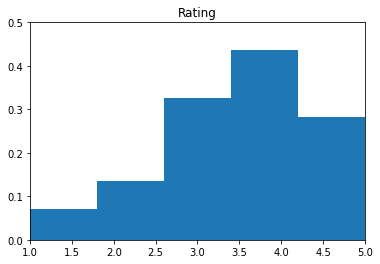

In [20]:
plt.hist(data['Rating'], density=True, bins=5)
plt.title('Rating')
plt.axis([1, 5, 0, 0.5])
plt.show()

In [21]:
#ratings
data = data[data['Rating']>2]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


- 전체 데이터가 약 100만개에서 80만개로 줄었다

In [22]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_view) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_view)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data
user_len = data.groupby('UserId').size()
item_popular = data.groupby('ItemId').size()

print(user_len.mean())
print(item_popular.mean())

138.51266766020865
230.56174200661522


- 한명의 user는 평균 138편의 영화를 봤고, item은 평균 230회 시청되었다.
- 너무 적은 데이터 (한번만 시청된 item, 5번 이하로 시청한 user)는 제거한다.

In [23]:
data = cleanse_recursive(data, shortest=4, least_view=2)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## | Train, Valid, Test split

In [24]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max().sort_values()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    
    before_date = user_in_train
    after_date = user_in_test
    return before_date, after_date
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')
    
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 819265
	 Users: 6036
	 Items: 3509
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:14:13

* valid Set Stats Info
	 Events: 9795
	 Users: 390
	 Items: 2372
	 First Time : 2002-03-05 04:24:20
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 7298
	 Users: 333
	 Items: 2064
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



In [25]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 2. 미니 배치의 구성
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.



In [26]:
#세션 데이터셋
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [27]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [28]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 818870, 818989, 819265], dtype=int32)

In [29]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6033, 6034, 6035])

In [30]:
#미니배치
#동일한 세션 길이를 가진 여러 사용자의 세션을 함께 묶어서 미니배치를 구성할 수 있다.
#이렇게 함으로써 학습 속도의 저하를 최소화할 수 있다.

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [31]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head()

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4


In [32]:
iter_ex = iter(tr_data_loader)

In [33]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


# 3. 모델 구성
이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.



In [34]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [36]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [37]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        pred = model.predict(input_ohe, batch_size=args.batch_size)
#         pred_arg = tf.nn.top_k(pred, k=124, sorted=True)[1]  # softmax 값이 큰 순서대로 sorting 합니다.
        pred_arg = tf.argsort(pred, direction='DESCENDING')
    
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [38]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

# 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.
- batch_size=256,
hsz=50,
drop_rate=0.1,
lr=0.001,
epochs=5,
k=20

In [39]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3509)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    534150    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3509)               178959    
Total params: 713,109
Trainable params: 713,109
Non-trainable params: 0
_________________________________________________________________


Evaluation:  17%|█▋        | 6/36 [00:07<00:35,  1.17s/it]


	 - Recall@20 epoch 1: 0.054036
	 - MRR@20    epoch 1: 0.013468



Evaluation:  17%|█▋        | 6/36 [00:06<00:32,  1.10s/it]


	 - Recall@20 epoch 2: 0.093099
	 - MRR@20    epoch 2: 0.025710



Evaluation:  17%|█▋        | 6/36 [00:06<00:32,  1.09s/it]


	 - Recall@20 epoch 3: 0.102865
	 - MRR@20    epoch 3: 0.029558



Evaluation:  17%|█▋        | 6/36 [00:06<00:32,  1.09s/it]


	 - Recall@20 epoch 4: 0.109375
	 - MRR@20    epoch 4: 0.031938



Evaluation:  17%|█▋        | 6/36 [00:06<00:32,  1.09s/it]

	 - Recall@20 epoch 5: 0.111328
	 - MRR@20    epoch 5: 0.033889



# 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [40]:
test_model(model, args, test)

Evaluation:   7%|▋         | 2/27 [00:02<00:27,  1.09s/it]

	 - Recall@20: 0.115234
	 - MRR@20: 0.036987



# 6. Step 6. 하이퍼 파라미터 변경
## | Batch size 조절
- batch_size = 128, 나머지 동일

In [41]:
args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3509)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    534150    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3509)               178959    
Total params: 713,109
Trainable params: 713,109
Non-trainable params: 0
_________________________________________________________________


Evaluation:  48%|████▊     | 35/73 [00:20<00:21,  1.74it/s]


	 - Recall@20 epoch 1: 0.093973
	 - MRR@20    epoch 1: 0.022677



Evaluation:  48%|████▊     | 35/73 [00:19<00:21,  1.78it/s]


	 - Recall@20 epoch 2: 0.116295
	 - MRR@20    epoch 2: 0.032393



Evaluation:  48%|████▊     | 35/73 [00:19<00:21,  1.78it/s]


	 - Recall@20 epoch 3: 0.122991
	 - MRR@20    epoch 3: 0.034020



Evaluation:  48%|████▊     | 35/73 [00:19<00:21,  1.78it/s]


	 - Recall@20 epoch 4: 0.129911
	 - MRR@20    epoch 4: 0.036742



Evaluation:  48%|████▊     | 35/73 [00:19<00:21,  1.77it/s]

	 - Recall@20 epoch 5: 0.131920
	 - MRR@20    epoch 5: 0.037861



In [42]:
test_model(model2, args2, test)

Evaluation:  37%|███▋      | 20/54 [00:11<00:18,  1.79it/s]

	 - Recall@20: 0.147656
	 - MRR@20: 0.041902



- batch_size = 64, 나머지 동일

In [43]:
args3 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model3 = create_model(args3)
train_model(model3, args3)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3509)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      534150    
_________________________________________________________________
dropout_2 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (64, 3509)                178959    
Total params: 713,109
Trainable params: 713,109
Non-trainable params: 0
_________________________________________________________________


Evaluation:  72%|███████▏  | 105/146 [00:31<00:12,  3.32it/s]


	 - Recall@20 epoch 1: 0.107738
	 - MRR@20    epoch 1: 0.027666



Evaluation:  72%|███████▏  | 105/146 [00:31<00:12,  3.34it/s]


	 - Recall@20 epoch 2: 0.120833
	 - MRR@20    epoch 2: 0.032538



Evaluation:  72%|███████▏  | 105/146 [00:31<00:12,  3.38it/s]


	 - Recall@20 epoch 3: 0.129018
	 - MRR@20    epoch 3: 0.035059



Evaluation:  72%|███████▏  | 105/146 [00:31<00:12,  3.37it/s]


	 - Recall@20 epoch 4: 0.135863
	 - MRR@20    epoch 4: 0.038027



Evaluation:  72%|███████▏  | 105/146 [00:31<00:12,  3.35it/s]

	 - Recall@20 epoch 5: 0.138988
	 - MRR@20    epoch 5: 0.039721



In [44]:
test_model(model3, args3, test)

Evaluation:  59%|█████▉    | 64/108 [00:18<00:12,  3.40it/s]

	 - Recall@20: 0.153076
	 - MRR@20: 0.046408



- batch size가 작아질수록 Recall과 MRR이 향상된다

## | lr 조절
- lr = 0.01, 나머지 동일

In [45]:
args4 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.01, epochs=5, k=20)
model4 = create_model(args4)
train_model(model4, args4)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3509)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      534150    
_________________________________________________________________
dropout_3 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (64, 3509)                178959    
Total params: 713,109
Trainable params: 713,109
Non-trainable params: 0
_________________________________________________________________


Evaluation:  72%|███████▏  | 105/146 [00:31<00:12,  3.29it/s]


	 - Recall@20 epoch 1: 0.116518
	 - MRR@20    epoch 1: 0.030387



Evaluation:  72%|███████▏  | 105/146 [00:31<00:12,  3.33it/s]


	 - Recall@20 epoch 2: 0.116667
	 - MRR@20    epoch 2: 0.030404



Evaluation:  72%|███████▏  | 105/146 [00:32<00:12,  3.24it/s]


	 - Recall@20 epoch 3: 0.117560
	 - MRR@20    epoch 3: 0.028805



Evaluation:  72%|███████▏  | 105/146 [00:32<00:12,  3.28it/s]


	 - Recall@20 epoch 4: 0.117708
	 - MRR@20    epoch 4: 0.030146



Evaluation:  72%|███████▏  | 105/146 [00:31<00:12,  3.31it/s]

	 - Recall@20 epoch 5: 0.118899
	 - MRR@20    epoch 5: 0.030261



In [46]:
test_model(model4, args4, test)

Evaluation:  59%|█████▉    | 64/108 [00:18<00:12,  3.39it/s]

	 - Recall@20: 0.136963
	 - MRR@20: 0.035173



- lr = 0.005, 나머지 동일

In [47]:
args5 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.005, epochs=5, k=20)
model5 = create_model(args5)
train_model(model5, args5)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(64, 1, 3509)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      534150    
_________________________________________________________________
dropout_4 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (64, 3509)                178959    
Total params: 713,109
Trainable params: 713,109
Non-trainable params: 0
_________________________________________________________________


Evaluation:  72%|███████▏  | 105/146 [00:31<00:12,  3.35it/s]


	 - Recall@20 epoch 1: 0.126786
	 - MRR@20    epoch 1: 0.033455



Evaluation:  72%|███████▏  | 105/146 [00:30<00:12,  3.39it/s]


	 - Recall@20 epoch 2: 0.127827
	 - MRR@20    epoch 2: 0.033651



Evaluation:  72%|███████▏  | 105/146 [00:31<00:12,  3.37it/s]


	 - Recall@20 epoch 3: 0.127976
	 - MRR@20    epoch 3: 0.035044



Evaluation:  72%|███████▏  | 105/146 [00:31<00:12,  3.33it/s]


	 - Recall@20 epoch 4: 0.124554
	 - MRR@20    epoch 4: 0.035102



Evaluation:  72%|███████▏  | 105/146 [00:31<00:12,  3.34it/s]

	 - Recall@20 epoch 5: 0.123810
	 - MRR@20    epoch 5: 0.035479



In [48]:
test_model(model5, args5, test)

Evaluation:  59%|█████▉    | 64/108 [00:18<00:12,  3.44it/s]

	 - Recall@20: 0.145508
	 - MRR@20: 0.038231



- learning rate는 낮아질수록 Recall과 MRR이 높아지는 것 같다. 하지만 0.001 밑으로 너무 낮아지면 오히려 감소한다.

## | epoch 조절
- epoch = 10으로 증가시키면 ( 당연히 성능이 좋아질 것이다 )

In [ ]:
# args6 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.0005, epochs=10, k=20)
# model6 = create_model(args6)
# train_model(model6, args6)

In [ ]:
# test_model(model6, args6, test)

- epoch 늘렸더니 성능이 오른다

## 회고
- rating 1~2점인건 삭제, session length는 user당 몇 편의 영화를 보았는지의 갯수로 대체하였다
- 재밌는데, 모델 구성 부분과 class 부분 좀 더 공부 필요
- 하이퍼파라미터 일일이 수정해서 적용해보는 건 진짜 시간 많이 걸릴듯 싶다